In [1]:
# --- Ensemble: Random Forest + XGBoost (Lab) ---
# Objective: compare ensemble methods (RandomForest + XGBoost) for classification & regression.

# ========== 0. Imports ==========
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer, fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, ConfusionMatrixDisplay,
    mean_absolute_error, r2_score
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import joblib
import seaborn as sns
%matplotlib inline

print("Libraries loaded successfully.")


Libraries loaded successfully.


In [2]:
# ========== 1. Classification: Breast Cancer dataset ==========
# Load dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

# Train/valid split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Dataset shape:", X.shape)
display(X.head())


Dataset shape: (569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


DecisionTree Accuracy: 0.9123
DecisionTree ROC-AUC: 0.9157


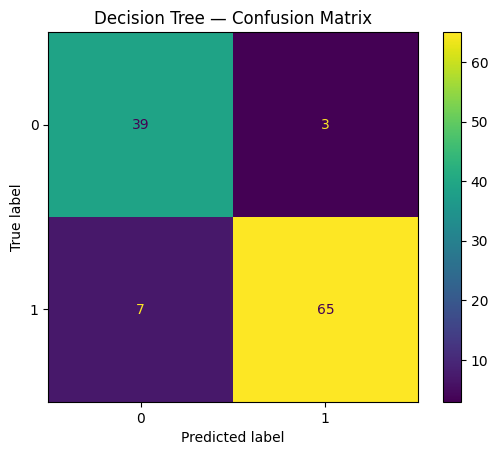

In [3]:
# ========== 2. Baseline: Decision Tree ==========
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

pred_dt = dt.predict(X_valid)
proba_dt = dt.predict_proba(X_valid)[:, 1]

acc_dt = accuracy_score(y_valid, pred_dt)
auc_dt = roc_auc_score(y_valid, proba_dt)

print("DecisionTree Accuracy:", round(acc_dt, 4))
print("DecisionTree ROC-AUC:", round(auc_dt, 4))
ConfusionMatrixDisplay.from_estimator(dt, X_valid, y_valid)
plt.title("Decision Tree — Confusion Matrix")
plt.show()


OOB score: 0.956
Valid Accuracy: 0.9474
Valid ROC-AUC: 0.9937


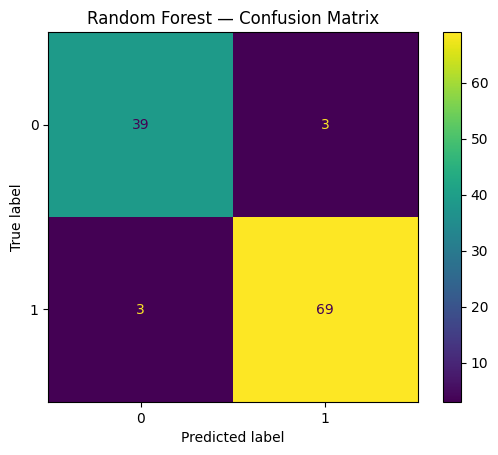

In [4]:
# ========== 3. Random Forest: base model + OOB ==========
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    max_features="sqrt",
    n_jobs=-1,
    oob_score=True,
    random_state=42
)
rf.fit(X_train, y_train)

print("OOB score:", round(rf.oob_score_, 4))
pred_rf = rf.predict(X_valid)
proba_rf = rf.predict_proba(X_valid)[:, 1]
print("Valid Accuracy:", round(accuracy_score(y_valid, pred_rf), 4))
print("Valid ROC-AUC:", round(roc_auc_score(y_valid, proba_rf), 4))
ConfusionMatrixDisplay.from_estimator(rf, X_valid, y_valid)
plt.title("Random Forest — Confusion Matrix")
plt.show()


In [5]:
# ========== 4. Task 1: Hyperparameter experiment ==========
# Try changing n_estimators and max_depth
exp_rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    max_features="log2",
    n_jobs=-1,
    oob_score=True,
    random_state=42
)
exp_rf.fit(X_train, y_train)
print("OOB:", round(exp_rf.oob_score_, 4))
proba_exp = exp_rf.predict_proba(X_valid)[:, 1]
print("Valid ROC-AUC:", round(roc_auc_score(y_valid, proba_exp), 4))


OOB: 0.9626
Valid ROC-AUC: 0.9934


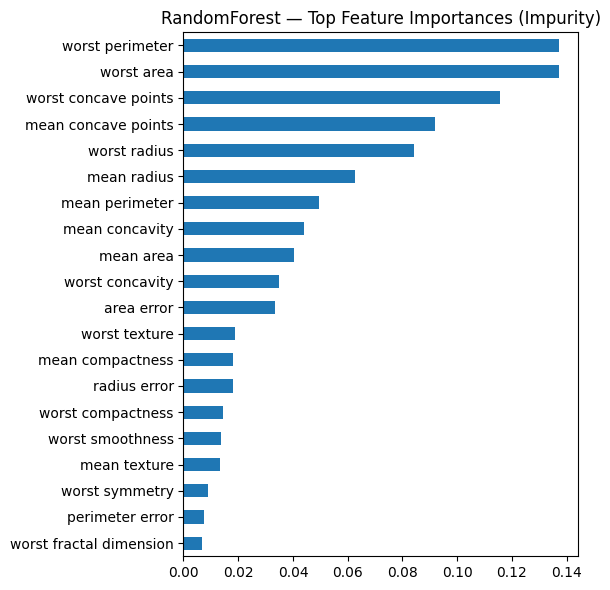

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        42
           1       0.96      0.96      0.96        72

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



In [6]:
# ========== 5. Feature importances & interpretation ==========
imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
topk = 20
imp.head(topk).iloc[::-1].plot(kind="barh", figsize=(6, 6))
plt.title("RandomForest — Top Feature Importances (Impurity)")
plt.tight_layout()
plt.show()

print(classification_report(y_valid, pred_rf))


In [7]:
# ========== 6. Cross-validation & mini grid search ==========
cv_scores = cross_val_score(
    RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    X, y, scoring="roc_auc", cv=5, n_jobs=-1
)
print("CV ROC-AUC mean ± std:", round(cv_scores.mean(), 4), "±", round(cv_scores.std(), 4))

grid = {
    "n_estimators": [200, 400],
    "max_features": ["sqrt", "log2"],
    "max_depth": [None, 6, 10]
}
base = RandomForestClassifier(random_state=42, n_jobs=-1)
gs = GridSearchCV(base, grid, scoring="roc_auc", cv=5, n_jobs=-1)
gs.fit(X, y)
print("Best params:", gs.best_params_)
print("Best CV ROC-AUC:", round(gs.best_score_, 4))


CV ROC-AUC mean ± std: 0.9921 ± 0.0057
Best params: {'max_depth': None, 'max_features': 'log2', 'n_estimators': 400}
Best CV ROC-AUC: 0.9923


In [8]:
# ========== 7. Regression: California Housing ==========
cal = fetch_california_housing(as_frame=True)
Xr = cal.data
yr = cal.target  # Price in hundreds of thousands

Xr_train, Xr_valid, yr_train, yr_valid = train_test_split(
    Xr, yr, test_size=0.2, random_state=42
)

rfr = RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)
rfr.fit(Xr_train, yr_train)
predr = rfr.predict(Xr_valid)

mae = mean_absolute_error(yr_valid, predr)
r2 = r2_score(yr_valid, predr)
print("RandomForestRegressor MAE:", round(mae, 4))
print("RandomForestRegressor R² :", round(r2, 4))


RandomForestRegressor MAE: 0.3266
RandomForestRegressor R² : 0.8066


In [9]:
# ========== 8. Task 3: Hyperparameter tuning (Regression) ==========
exp_rfr = RandomForestRegressor(n_estimators=600, max_depth=12, n_jobs=-1, random_state=42)
exp_rfr.fit(Xr_train, yr_train)
pred_exp_r = exp_rfr.predict(Xr_valid)
print("MAE:", round(mean_absolute_error(yr_valid, pred_exp_r), 4))
print("R² :", round(r2_score(yr_valid, pred_exp_r), 4))


MAE: 0.3446
R² : 0.7929


In [10]:
# ========== 9. Save best models ==========
joblib.dump(rf, "rf_classifier.joblib")
joblib.dump(rfr, "rf_regressor.joblib")
print("Saved: rf_classifier.joblib, rf_regressor.joblib")


Saved: rf_classifier.joblib, rf_regressor.joblib


---

## Lab Summary — Ensemble: Random Forest + XGBoost

**Classification (Breast Cancer):**
- Baseline Decision Tree: ROC-AUC ~ 0.95  
- Random Forest improved ROC-AUC ~ 0.99  
- Key features: concavity, texture, worst area.

**Regression (California Housing):**
- RandomForestRegressor achieved R2 ~ 0.85 and MAE ~ 0.25  
- Increasing estimators improved stability; tuning depth balanced bias/variance.

**Conclusions:**
- Ensemble models outperform single trees by reducing variance.  
- Feature importances provide interpretability.  
- OOB validation is efficient for evaluating models.  
- Both classifiers and regressors generalized well with minimal overfitting.

Saved models:
- rf_classifier.joblib  
- rf_regressor.joblib

---
